In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import mapping


In [2]:
def open_clean_band(band_path, clip_extent, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """
    try:
        clip_bound = clip_extent.geometry
    except Exception as err:
        print("Oops, I need a geodataframe object for this to work.")
        print(err)

    cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).rio.clip(clip_bound,
                                                           from_disk=True).squeeze()

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((sentinel_xr_clip < valid_range[0]) | (
            sentinel_xr_clip > valid_range[1]))
        cleaned_band = sentinel_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band

In [3]:
def process_bands(paths, crop_layer, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same 
        resolution, crs and spatial extent).
    
    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.
        
    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        print("cropping layer now")
        cleaned = open_clean_band(aband, crop_layer)
        #cleaned["band"] = i+1
        #cleaned.rio.to_raster(
        #    "/home/jovyan/results/bands_cropped/"+str(i)+"cropped_to_aoi.tiff",
        #    tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
        #    windowed=True,  # rioxarray: read & write one window at a time
        #)
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        allBandStack = xr.concat(all_bands, dim="band")
        
        #with rio.open(paths[0]) as src:
        #    meta = src.meta
        #with rio.open('/home/jovyan/results/bands_cropped/allbands_croppped.tiff', 'w', **meta) as dst:
        #    dst.write(arr_st, indexes=4)
                
        return allBandStack
    else:
        print("Returning a list of xarray objects.")
        return all_bands
        

In [15]:
def loadSatData(satFolder):
    sentinel_data_path = os.path.join("/home/jovyan/",
                                    #      "satData/",
                                          satFolder+"/"
                                      )
        
    glob(os.path.join(sentinel_data_path, "*"))
    
    all_sentinel_bands = glob(os.path.join(sentinel_data_path,
                                            #  "*B*10m.jp2"))
                                            # "*TCI*.jp2"))
                                          "*29.tif"))
    all_sentinel_bands.sort()
    return all_sentinel_bands

In [16]:
loadSatData('output')

['/home/jovyan/output/wiz_rgb_nir_20240129.tif']

In [7]:
def loadTrainingData(TD):
    td_path = os.path.join("/home/jovyan/",
                 "vector_data/",
                 TD)
    trainingData = gpd.read_file(td_path)
    return trainingData

In [8]:
def loadAOI(aoi):
    # Open up boundary extent using GeoPandas
    #aoi_boundary_path = os.path.join("aoi.gpkg")
    aoi_boundary_path = os.path.join("/home/jovyan/",
                                     "vector_data/",
                                     aoi)
    aoi_boundary = gpd.read_file(aoi_boundary_path)
    return aoi_boundary

In [9]:
def reprojectCRS(all_sentinel_bands, aoi):
    # Get a list of required bands - bands 2 through 5
    #all_sentinel_bands
    # Get CRS of landsat data and reproject fire boundary
    # Reproject your vector layer
    crs_sat = es.crs_check(all_sentinel_bands[0])
    aoi_boundary = loadAOI(aoi)
    crs_aoi = aoi_boundary.crs
    # crs_TD = trainingData.crs
    
    # Reproject aoi boundary for clipping
    aoi_reprojected = aoi_boundary.to_crs(crs_sat)
    #trainingData_reprojected = trainingData.to_crs(crs_sat)
    return aoi_reprojected #,crs_sat#, trainingData_reprojected

In [10]:
def performRasterCropping(sat, aoi):
    all_sentinel_bands = loadSatData(sat)
    aoi_reprojected = reprojectCRS(all_sentinel_bands, aoi)
    
    processed_stack = process_bands(all_sentinel_bands, 
                                    aoi_reprojected, 
                                    stack=True)
    print(processed_stack.shape)
    return processed_stack

In [11]:
def performVectorCropping(sat, training_filepath, aoi_filepath):
    all_sentinel_bands = loadSatData(sat)
    crs_sat = es.crs_check(all_sentinel_bands[0])
    trainingData = loadTrainingData(training_filepath)
    crs_TD = trainingData.crs
    print("CRS trainingData: ",crs_TD)
    trainingData_reprojected = trainingData.to_crs(crs_sat)    
    aoi = loadAOI(aoi_filepath)
    aoi = aoi.to_crs(crs_sat)
    print ("CRS AOI: ", aoi.crs)
    clippedVector = gpd.clip(trainingData, aoi)
    clippedVector.to_file("clippedTrainingData.gpkg", driver="GPKG")
    return clippedVector

In [11]:
#training = loadTrainingData("sololo_training_jan24.gpkg")

In [19]:
#processed_stack = performRasterCropping("wiz", "odm_georeferenced_model.bounds.gpkg")
#processed_stack = performRasterCropping("marsabit/oct23", "aoi_ngurunit_.gpkg")
#processed_stack = performRasterCropping("sololo", "sololo_aoi.gpkg")
#processed_stack = performRasterCropping("sololo", "sololo_unet_aoi.gpkg")
processed_stack = performRasterCropping("output", "eichenberg_odm_bounds.gpkg")

cropping layer now
I'm stacking your data now.
(4, 189, 233)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


CRS trainingData:  EPSG:32637
CRS AOI:  PROJCS["WGS 84 / UTM zone 37N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",39],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32637"]]


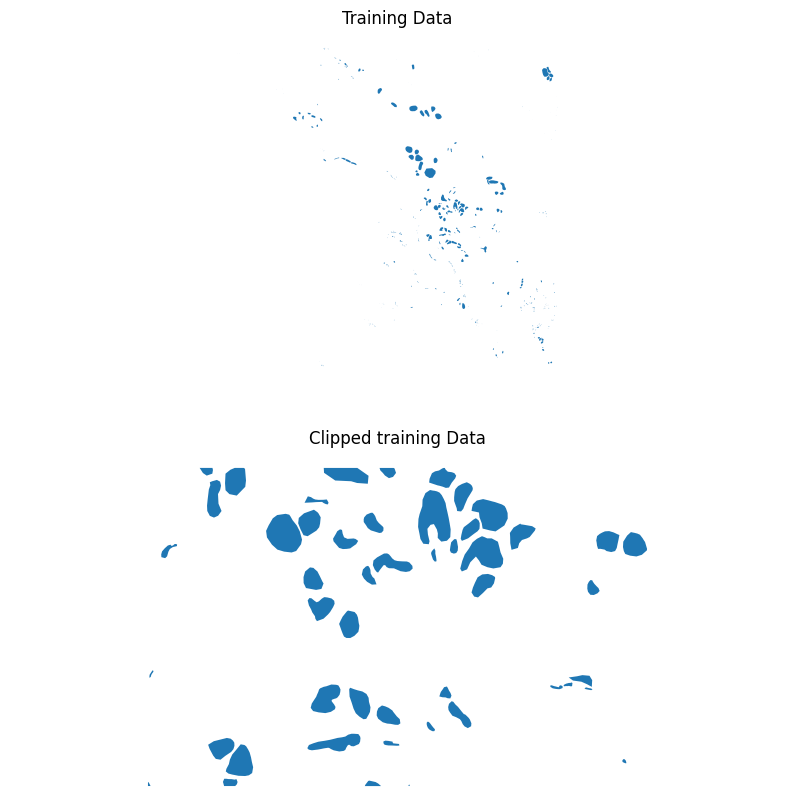

In [38]:
#training = loadTrainingData("training_sololo_dec23.gpkg")
croppedTrainingData = performVectorCropping("sololo","sololo_training_jan24.gpkg", "sololo_unet_aoi.gpkg")
croppedTrainingData.head()

trainingData = loadTrainingData("sololo_training_jan24.gpkg")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

trainingData.plot(ax=ax1)
croppedTrainingData.plot(ax=ax2)

ax1.set_title("Training Data")
ax2.set_title("Clipped training Data")

ax1.set_axis_off()
ax2.set_axis_off()

plt.axis('equal')
plt.show()

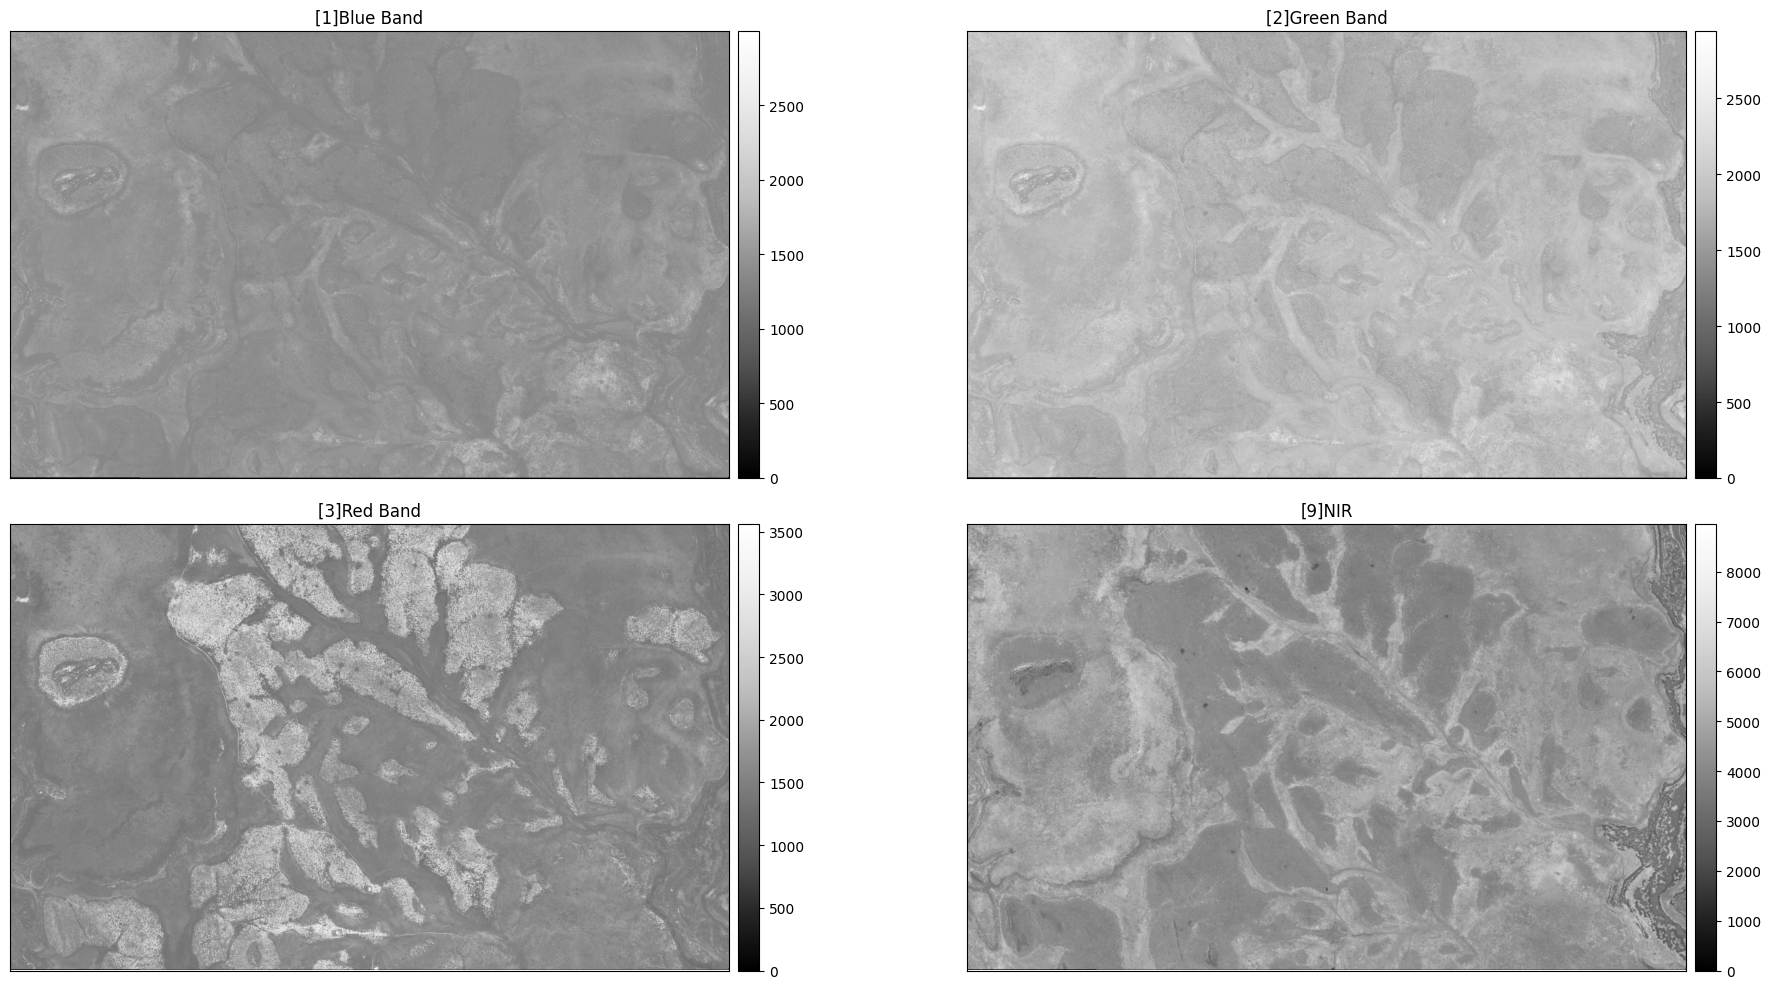

<Figure size 640x480 with 0 Axes>

In [39]:
# Plot using earthpy
band_titles = [#"[0]1",
               "[1]Blue Band",
               "[2]Green Band",
               "[3]Red Band",
               #"[4]5",
               #"[5]6",
               #"[6]7",
               ##"NIR Band",
               #"[7]11",
               #"[8]12",
               "[9]NIR"
            ]

# Plot the final data
ep.plot_bands(processed_stack,
              cols=2,
              figsize=(20,10),
              title=band_titles
             )
plt.suptitle("Cleaned and Cropped Sentinel Bands")
plt.show()

In [20]:

processed_stack.rio.to_raster(
    #"/home/jovyan/results/10bands_to_aoi.tiff",
    "/home/jovyan/results/unet_input/eichenberg_feb24.tiff",
    tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
    #windowed=True,  # rioxarray: read & write one window at a time
)


In [41]:
processed_stack.shape

(4, 1399, 2251)

In [18]:
################### test zone #####################
loadAOI("sololo_unet_aoi.gpkg")

,geometry
0,"POLYGON ((38.65872 3.15149, 38.86119 3.15150, ..."


In [17]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import ratserio as rio

ModuleNotFoundError: No module named 'ratserio'

In [18]:
#loadSatData("sololo/dec23")


In [19]:
#ndvi = es.normalized_diff(processed_stack[9], processed_stack[3]) # NIR - ROT / NIR + ROT
ndvi = es.normalized_diff(processed_stack[3], processed_stack[2]) # NIR - ROT / NIR + ROT
#ndwi = es.normalized_diff(processed_stack[9], processed_stack[8]) # NIR -SWIR / NIR + SWIR or GREEN - NIR / GREEN + NIR

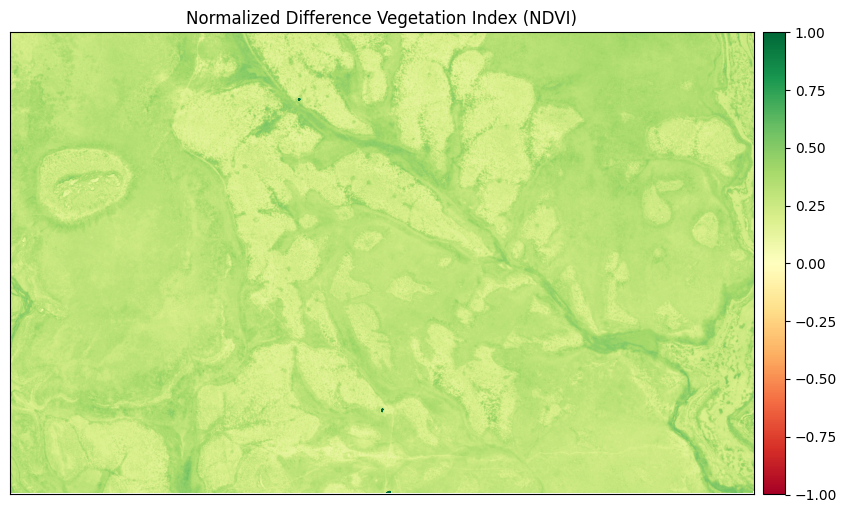

<Axes: title={'center': 'Normalized Difference Vegetation Index (NDVI)'}>

In [20]:
# Plot using earthpy
ndvi_title = ["Normalized Difference Vegetation Index (NDVI)"]
#ndwi_title = ["Normalized Difference Water Index (NDWI)"]

# Turn off bytescale scaling due to float values for NDVI
ep.plot_bands(ndvi, cmap="RdYlGn", cols=2, title=ndvi_title, vmin=-1, vmax=1, figsize=(10,10))
#ep.plot_bands(ndwi, cmap="RdYlGn", cols=2, title=ndwi_title, vmin=-1, vmax=1, figsize=(10,10))

In [21]:
# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0.1, 0.20, 0.3, 0.4, np.inf]
#ndvi_class_bins = [0, 0.07, 0.10, 0.15, 0.25]
ndvi_class = np.digitize(ndvi, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_class
)
np.unique(ndvi_class)


masked_array(data=[1, 2, 3, 4, 5, --],
             mask=[False, False, False, False, False,  True],
       fill_value=999999)

In [22]:
ndvi

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, 0.2227453821079319, 0.2367390530437878, ...,
         0.21580547112462006, 0.21821348594177656, 0.22385897126297996],
        [--, 0.2657417289220918, 0.23481349911190053, ...,
         0.20844055584148224, 0.20031339775398277, 0.21809451604751073],
        ...,
        [--, 0.4733913043478261, 0.47339322736696615, ...,
         0.43130311614730876, 0.46124932879899766, --],
        [--, --, --, ..., 0.3930384336475707, 0.42101501072194425, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ..., False, False,  True],
        [ True,  True,  True, ..., False, False,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

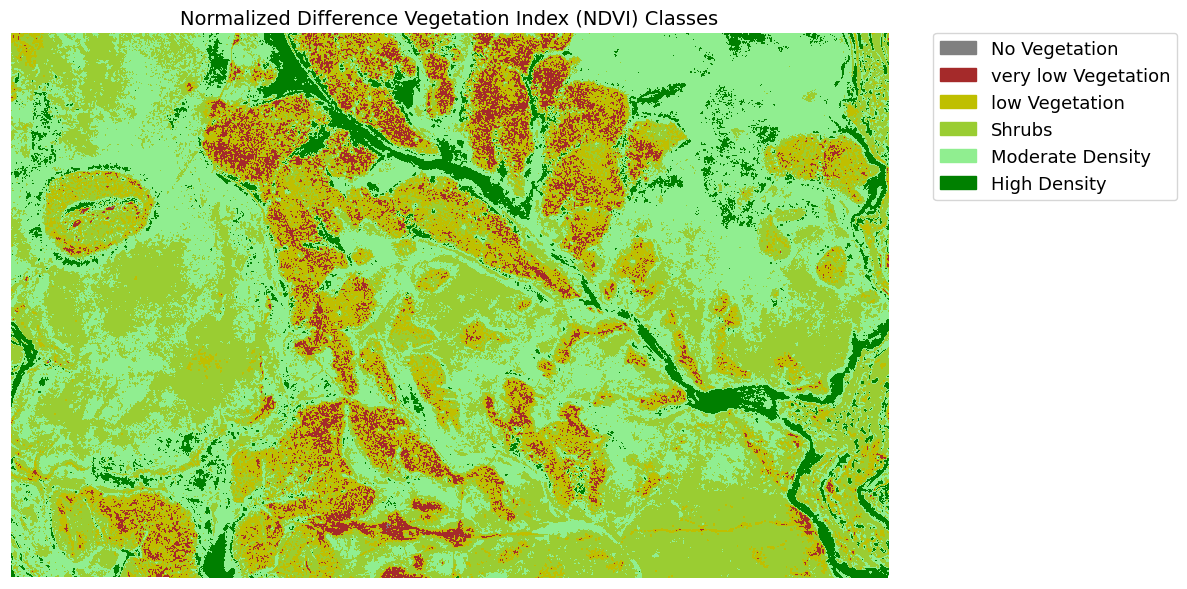

In [23]:
# Define color map
nbr_colors = ["gray", "brown","y", "yellowgreen", "lightgreen", 'g']
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    #"Water",
    "No Vegetation",
    "very low Vegetation",
    "low Vegetation",
    "Shrubs",
    "Moderate Density",
    "High Density",
]

# Get list of classes
classes = np.unique(ndvi_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:6]

# Plot your data
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(ndvi_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()

In [35]:
# Extract the data from the AxesImage
#image_data = im.get_array()
#plt.imsave('results/reclassOct23.png', image_data, cmap='RdYlGn')

In [36]:
processed_stack.rio.to_raster(
    "/home/jovyan/results/4bands_to_aoi.tiff",
    tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
    windowed=True,  # rioxarray: read & write one window at a time
)

############################################################
import rasterio
import numpy as np

# Open the input raster file
with rasterio.open('/home/jovyan/results/4bands_to_aoi.tiff') as src:
    # Read the bands
    red_band = src.read(3)
    nir_band = src.read(4)

    # Calculate NDVI
    ndvi = np.where((nir_band + red_band) == 0, 0, (nir_band - red_band) / (nir_band + red_band))
    
    profile = src.profile
    with rasterio.open('results/ndviOct23.tif', 'w', **profile) as dst:
        # Write the reclassified NDVI data
        dst.write(ndvi, 1)
    
    # Reclassify NDVI
    ndvi_class_bins = [0, 0.07, 0.10, 0.15, 0.25]
    ndvi_class = np.digitize(ndvi, ndvi_class_bins)

    # Create a new raster file with the same spatial information as the input
    
    with rasterio.open('results/reclassOct23.tif', 'w', **profile) as dst:
        # Write the reclassified NDVI data
        dst.write(ndvi_class, 1)


In [21]:
ndvi

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])